In [11]:
#Librairies
import pandas as pd
import numpy as np
import math
from datetime import timezone, datetime, timedelta

import matplotlib.pyplot as plt

from pyproj import Geod

from shapely.geometry import MultiLineString
from shapely.ops import polygonize
import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import sjoin

import os,sys,inspect

import contextily as ctx
from rasterio.crs import CRS
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [12]:
df_dev = pd.read_csv('donnees_GNSS_Europa.csv', sep=',', header=0)

In [13]:
df_dev.head()

devadd  gatewayid   timestamp  snr  rssi        lat        lng    ehpe  \
0  1ff0fe9c          0  1610930653   13   -70 -22.343824  40.340537  79.282   
1  1ff0fe9c          0  1610930772   13   -65 -22.343997  40.340147  27.729   
2  1ff0fe9c          0  1610930891   12   -67 -22.344038  40.340096   4.570   
3  1ff0fe9c          0  1610931010    8   -67 -22.344044  40.340106   3.690   
4  1ff0fe9c          0  1610931129    9   -67 -22.344044  40.340106   3.669   

    hdop  ttf  nbSat  noFixCount  zeroSatTimeout  
0  10300    0     16           0               0  
1   1230    0     16           0               0  
2    990    0     20           0               0  
3    960    0     19           0               0  
4    960    0     19           0               0

In [14]:
df_gtw = pd.read_csv('Suivi_info_gateway_tortue.csv', sep=',', header=0)

In [15]:
df_gtw.head()

Pseudo    model               eui sub-network role in network  short ID  \
0      Main  RAK7249  ac1f09fffe00a96d      Europa         Main GW         0   
1      dune  RAK7249  ac1f09fffe00a84f      Europa    Secondary GW         5   
2     lagon  RAK7249  ac1f09fffe00a8d6      Europa    Secondary GW         3   
3  mangrove  RAK7249  ac1f09fffe00a8d2      Europa    Secondary GW         4   

  Program loaded  ping freq               System time           Id / pwd  \
0       Main-gtw         no  UTC (updated 01/06/2021)  root / ifremer974   
1  Secondary-gtw  868.3 MHz  UTC (updated 01/06/2021)        root / root   
2  Secondary-gtw  867.7 MHz  UTC (updated 01/06/2021)        root / root   
3  Secondary-gtw  867.3 MHz  UTC (updated 01/06/2021)        root / root   

  Tunnel VPN Openvpn name Target application network  Longitude   Latitude  
0  Disabled             -                 Chirpstack  40.340192 -22.343807  
1   Disabled            -                 Chirpstack  40.372063 -22.342677  
2   Disabled            -                 Chirpstack  40.375278 -22.358056  
3   Disabled            -                 Chirpstack  40.391667 -22.364167

In [16]:
df = pd.DataFrame()
df = df_dev.drop(['devadd','hdop','ttf','nbSat','noFixCount','zeroSatTimeout'],axis=1)
df = pd.merge(df,df_gtw[['short ID', 'Pseudo','Longitude', 'Latitude']],left_on='gatewayid',right_on='short ID', how='left').drop('short ID', axis=1)
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.rename(columns={"lat": "objlat", "lng": "objlng", "Longitude":"gatewaylng", "Latitude":"gatewaylat", "Pseudo":"gatewayname"})
df.drop(df.index[df['rssi']>0], inplace = True)
df.head()

gatewayid           timestamp  snr  rssi     objlat     objlng    ehpe  \
0          0 2021-01-18 00:44:13   13   -70 -22.343824  40.340537  79.282   
1          0 2021-01-18 00:46:12   13   -65 -22.343997  40.340147  27.729   
2          0 2021-01-18 00:48:11   12   -67 -22.344038  40.340096   4.570   
3          0 2021-01-18 00:50:10    8   -67 -22.344044  40.340106   3.690   
4          0 2021-01-18 00:52:09    9   -67 -22.344044  40.340106   3.669   

  gatewayname  gatewaylng  gatewaylat  
0        Main   40.340192  -22.343807  
1        Main   40.340192  -22.343807  
2        Main   40.340192  -22.343807  
3        Main   40.340192  -22.343807  
4        Main   40.340192  -22.343807

In [17]:
wgs84_geod = Geod(ellps='WGS84')

def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
  return dist

#Distance en mètre
df['distancegps'] = Distance(df['gatewaylat'].tolist(),df['gatewaylng'].tolist(),df['objlat'].tolist(),df['objlng'].tolist())
df.head()

gatewayid           timestamp  snr  rssi     objlat     objlng    ehpe  \
0          0 2021-01-18 00:44:13   13   -70 -22.343824  40.340537  79.282   
1          0 2021-01-18 00:46:12   13   -65 -22.343997  40.340147  27.729   
2          0 2021-01-18 00:48:11   12   -67 -22.344038  40.340096   4.570   
3          0 2021-01-18 00:50:10    8   -67 -22.344044  40.340106   3.690   
4          0 2021-01-18 00:52:09    9   -67 -22.344044  40.340106   3.669   

  gatewayname  gatewaylng  gatewaylat  distancegps  
0        Main   40.340192  -22.343807    35.606578  
1        Main   40.340192  -22.343807    21.547111  
2        Main   40.340192  -22.343807    27.420959  
3        Main   40.340192  -22.343807    27.726208  
4        Main   40.340192  -22.343807    27.684867

In [18]:
grouped_gtw=df.groupby("gatewayname")

In [19]:
#Discretize
df['group_rssi'] = df['rssi'].transform(lambda x: pd.cut(x, bins = 20).astype(str))
df.head()

gatewayid           timestamp  snr  rssi     objlat     objlng    ehpe  \
0          0 2021-01-18 00:44:13   13   -70 -22.343824  40.340537  79.282   
1          0 2021-01-18 00:46:12   13   -65 -22.343997  40.340147  27.729   
2          0 2021-01-18 00:48:11   12   -67 -22.344038  40.340096   4.570   
3          0 2021-01-18 00:50:10    8   -67 -22.344044  40.340106   3.690   
4          0 2021-01-18 00:52:09    9   -67 -22.344044  40.340106   3.669   

  gatewayname  gatewaylng  gatewaylat  distancegps       group_rssi  
0        Main   40.340192  -22.343807    35.606578  (-72.7, -68.75]  
1        Main   40.340192  -22.343807    21.547111  (-68.75, -64.8]  
2        Main   40.340192  -22.343807    27.420959  (-68.75, -64.8]  
3        Main   40.340192  -22.343807    27.726208  (-68.75, -64.8]  
4        Main   40.340192  -22.343807    27.684867  (-68.75, -64.8]

In [20]:
step = 9
M = np.linspace(df['objlng'].min(), df['objlng'].max(), step)
N = np.linspace(df['objlat'].min(), df['objlat'].max(), step)

hlines = [((x1, yi), (x2, yi)) for x1, x2 in zip(M[:-1], M[1:]) for yi in N]
vlines = [((xi, y1), (xi, y2)) for y1, y2 in zip(N[:-1], N[1:]) for xi in M]

polys = list(polygonize(MultiLineString(hlines + vlines)))
idx = [i for i in range(len(polys))]
grid = gpd.GeoDataFrame({"id":idx,"geometry":polys})

In [21]:
df_geo = df.filter(['rssi','objlng','objlat','gatewayname', 'group_rssi'],axis=1)
gdf = gpd.GeoDataFrame(
    df_geo, geometry=gpd.points_from_xy(df_geo['objlng'], df_geo['objlat']))

grouped = gdf.groupby('gatewayname')

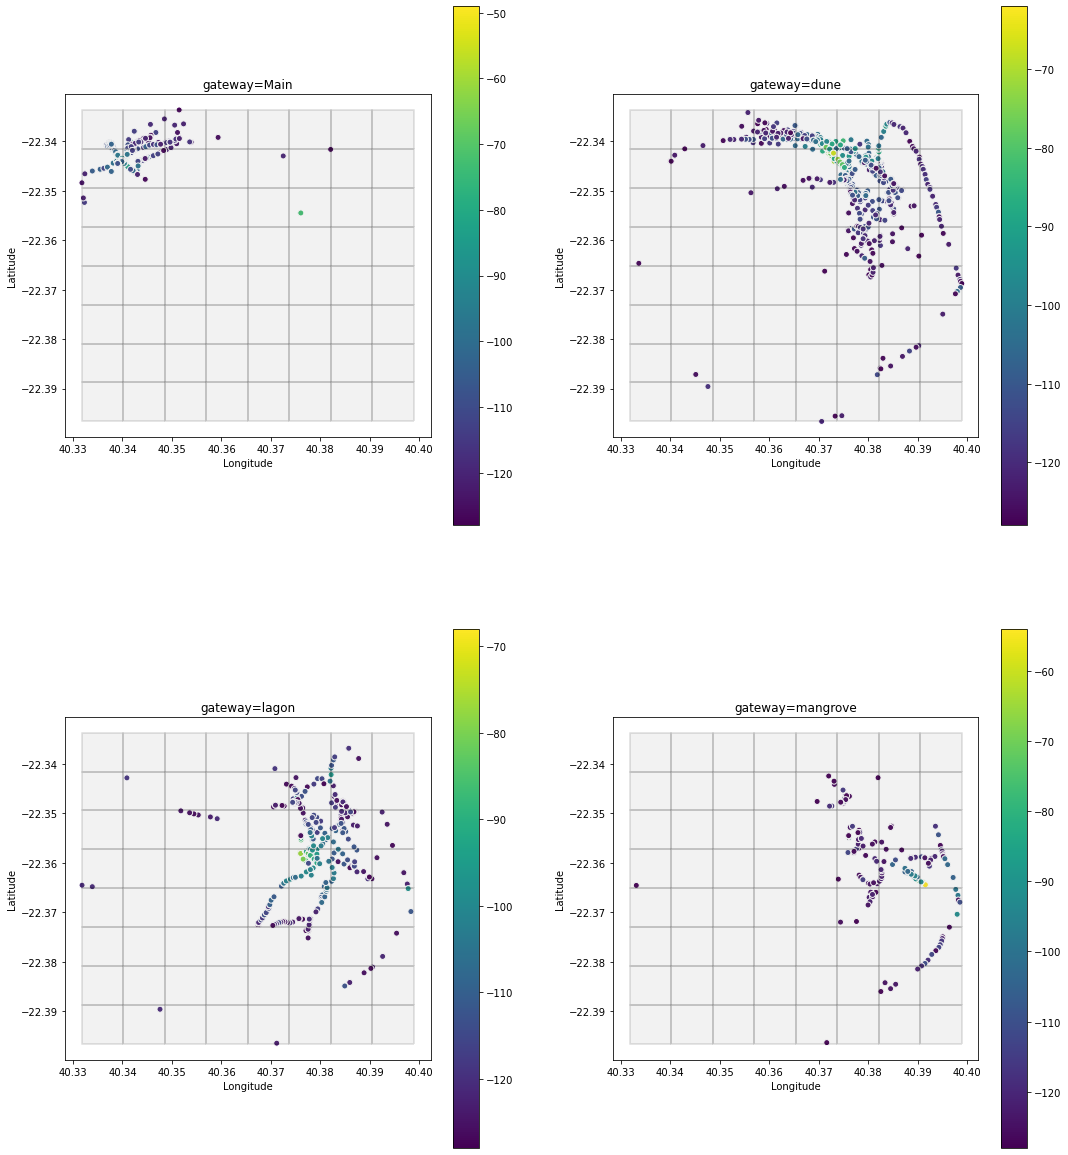

In [22]:
BBox=( df['objlng'].min(), df['objlng'].max(), df['objlat'].min(), df['objlat'].max())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,21),sharey=False)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot("rssi", cmap='viridis', ax=ax, edgecolors= "white",legend=True) 
    grid.plot(ax=ax,facecolor='gray',alpha=.1,edgecolor='black',lw=2)
    ax.set(xlabel="Longitude", ylabel="Latitude")
    ax.set_title('gateway=%s'%key)
    

In [23]:
pointInPolys = sjoin(gdf, grid, how='left')

In [24]:
pointInPolys.head()

rssi     objlng     objlat gatewayname       group_rssi  \
0   -70  40.340537 -22.343824        Main  (-72.7, -68.75]   
1   -65  40.340147 -22.343997        Main  (-68.75, -64.8]   
2   -67  40.340096 -22.344038        Main  (-68.75, -64.8]   
3   -67  40.340106 -22.344044        Main  (-68.75, -64.8]   
4   -67  40.340106 -22.344044        Main  (-68.75, -64.8]   

                     geometry  index_right  id  
0  POINT (40.34054 -22.34382)           14  14  
1  POINT (40.34015 -22.34400)            6   6  
2  POINT (40.34010 -22.34404)            6   6  
3  POINT (40.34011 -22.34404)            6   6  
4  POINT (40.34011 -22.34404)            6   6

In [25]:
df_proba_group_rssi = (
    pointInPolys.groupby(['gatewayname','group_rssi', 'id']).count() / pointInPolys.groupby(['gatewayname','group_rssi']).count()
)['rssi']\
.pipe(pd.DataFrame)\
.rename(columns = {'rssi': 'proba'})\
.reset_index()

df_proba_group_rssi.head()

gatewayname        group_rssi  id     proba
0        Main  (-100.35, -96.4]   6  0.791411
1        Main  (-100.35, -96.4]   7  0.006135
2        Main  (-100.35, -96.4]  14  0.171779
3        Main  (-100.35, -96.4]  15  0.003067
4        Main  (-100.35, -96.4]  45  0.027607

In [26]:
t = pd.merge(grid, df_proba_group_rssi, on='id',  how='right')
t['coords'] = t['geometry'].apply(lambda x: x.representative_point().coords[:])

In [27]:
t['coords'] = [coords[0] for coords in t['coords']]

In [28]:
t['tuples_plot'] = list(zip(t['group_rssi'], t['gatewayname']))

In [29]:
t.head()

id                                           geometry gatewayname  \
0   4  POLYGON ((40.34020 -22.36518, 40.33181 -22.365...        dune   
1   4  POLYGON ((40.34020 -22.36518, 40.33181 -22.365...       lagon   
2   4  POLYGON ((40.34020 -22.36518, 40.33181 -22.365...    mangrove   
3   5  POLYGON ((40.34020 -22.35731, 40.33181 -22.357...        Main   
4   5  POLYGON ((40.34020 -22.35731, 40.33181 -22.357...        Main   

            group_rssi     proba                                coords  \
0  (-128.079, -124.05]  0.006536  (40.3360025125, -22.361243112500002)   
1    (-124.05, -120.1]  0.017544  (40.3360025125, -22.361243112500002)   
2  (-128.079, -124.05]  0.009901  (40.3360025125, -22.361243112500002)   
3    (-116.15, -112.2]  0.022222  (40.3360025125, -22.353376737500003)   
4    (-124.05, -120.1]  0.027027  (40.3360025125, -22.353376737500003)   

                       tuples_plot  
0      ((-128.079, -124.05], dune)  
1       ((-124.05, -120.1], lagon)  
2  ((-128.079, -124.05], mangrove)  
3        ((-116.15, -112.2], Main)  
4        ((-124.05, -120.1], Main)

In [30]:
#len(grouped.groups.keys())

(nombre de paquets d'une plage du RSSI donnée qui appartienne à la cellule c(i,j)) / nombre total de paquet de la plage du RSSI. L'espace des RSSI est divisée en 20 classes. 

In [31]:
BBox=[df['objlng'].min(), df['objlng'].max(), df['objlat'].min(), df['objlat'].max()]
BBox

[40.331809299999996, 40.398900700000006, -22.3966418, -22.333710800000002]

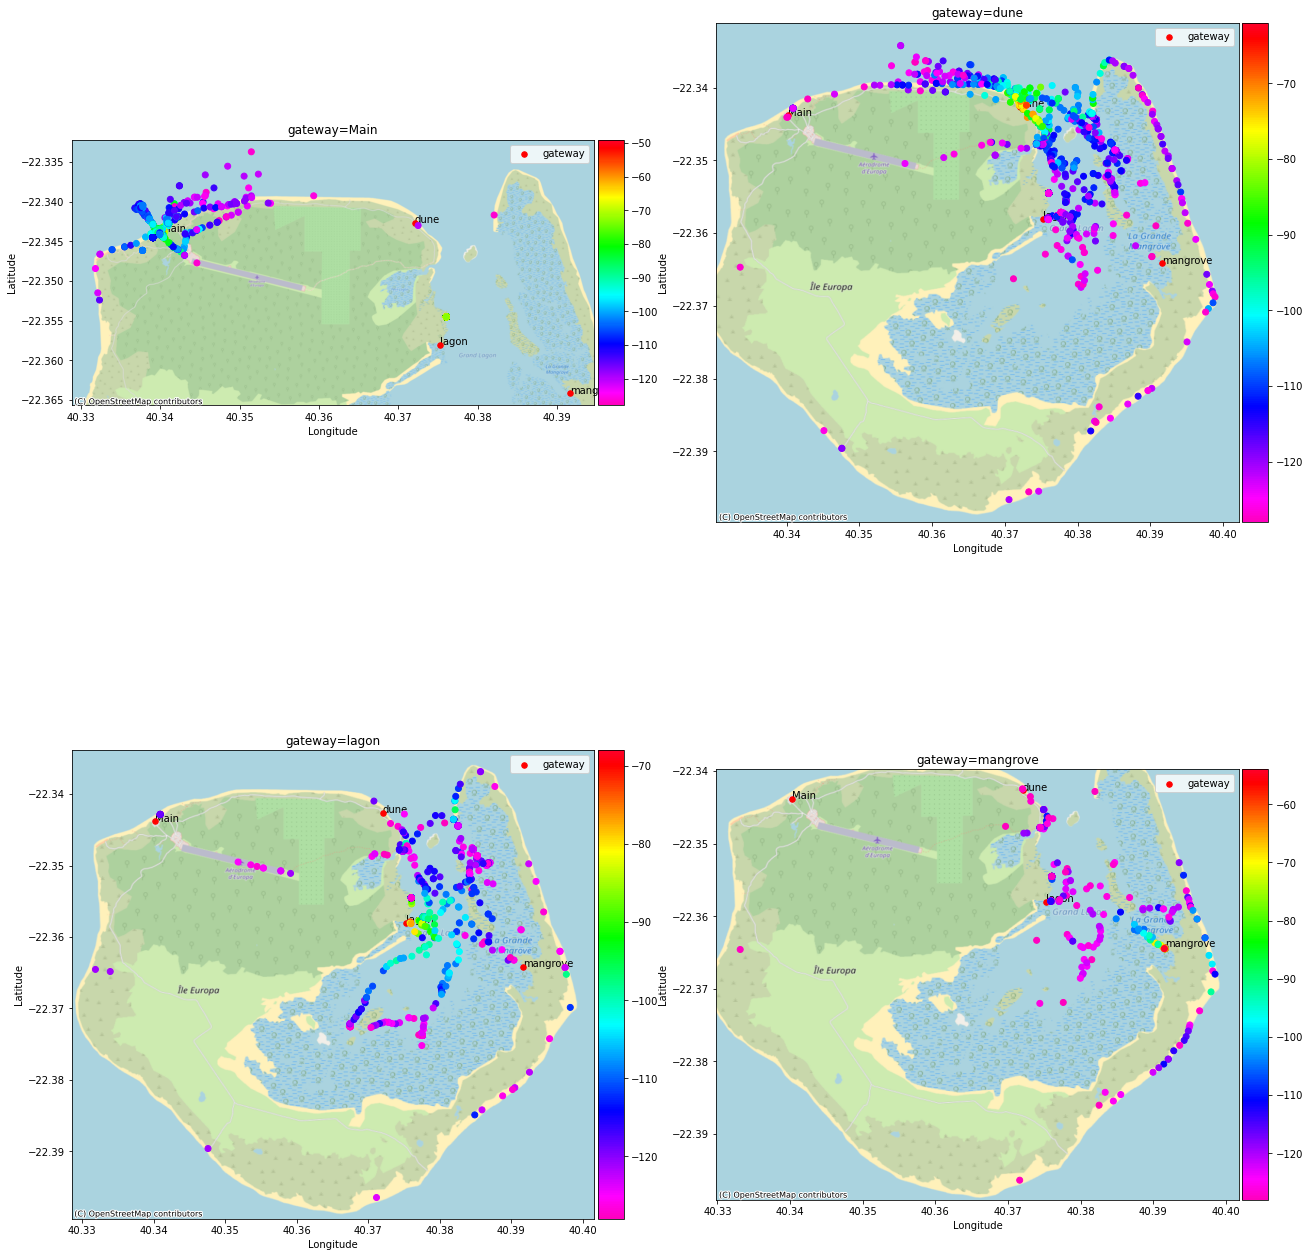

In [37]:
gdf = gpd.GeoDataFrame(df, crs = "EPSG:4326", geometry=gpd.points_from_xy(df['objlng'], df['objlat']))
grouped = gdf.groupby('gatewayname')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,21), sharey=False)


for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    # Add basemap
    hb = ax.scatter(x=grouped.get_group(key)['objlng'],y=grouped.get_group(key)['objlat'], c=grouped.get_group(key)['rssi'], cmap='gist_rainbow_r',zorder=30)
    ax.scatter(df_gtw['Longitude'],df_gtw['Latitude'],zorder=10,color='r', s=30, label="gateway")
    ax.set_title('gateway=%s'%key)
    ax.set(xlabel="Longitude", ylabel="Latitude")
    for i in range(df_gtw.shape[0]):
        ax.annotate(df_gtw['Pseudo'].tolist()[i], (df_gtw['Longitude'].tolist()[i], df_gtw['Latitude'].tolist()[i]))
    
    ctx.add_basemap(ax, crs=grouped.get_group(key).crs, reset_extent=True,source=ctx.providers.OpenStreetMap.Mapnik)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(hb,cax=cax)
    ax.legend()
    

plt.tight_layout(pad=0.01)

In [ ]:
crs = {'init':'EPSG:4326'}
gdf = gpd.GeoDataFrame(df, crs = "EPSG:4326", geometry=gpd.points_from_xy(df['objlng'], df['objlat']))
gdf.head()

In [ ]:
grouped = df.groupby('gatewayname')
#m=plt.imread('map.png')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,21), sharey=False)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    # Add basemap
    grouped.get_group(key).plot.scatter(ax=ax,x='objlng',y='objlat', c='rssi', cmap='Blues')
    ax.scatter(df_gtw['Longitude'],df_gtw['Latitude'],zorder=2,color='r', label="gateway")
    ax.set_title('gateway=%s'%key)
    ax.set(xlabel="Longitude", ylabel="Latitude")
    #ax.imshow(m,zorder=0,extent=BBox,aspect='equal')
    contextily.add_basemap(ax,crs="EPSG:4326",source=contextily.providers.Stamen.Watercolor)
    for i in range(df_gtw.shape[0]):
        ax.annotate(df_gtw['Pseudo'].tolist()[i], (df_gtw['Longitude'].tolist()[i], df_gtw['Latitude'].tolist()[i]))
    contextily.add_basemap(ax,crs="EPSG:4326",source=contextily.providers.Stamen.Watercolor)
plt.tight_layout()